In [184]:
from pathlib import Path

from dask import dataframe as dd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pearl.post_processing.bmi import calc_risk_by_group, clean_control, group_title_dict


In [185]:
baseline = Path("/workspaces/pearlModel/out/200_rep/S0_SA_200/combined")
variable = Path("/workspaces/pearlModel/out/200_rep/S3_SA_200/combined")

In [186]:
param_df_baseline = pd.read_parquet(baseline / "parameters.parquet").reset_index(drop=True)
param_df_variable = pd.read_parquet(variable / "parameters.parquet").reset_index(drop=True)

In [187]:
param_df_baseline.columns

Index(['replication', 'group', 'new_dx', 'final_year', 'mortality_model',
       'mortality_threshold_flag', 'idu_threshold', 'seed',
       'bmi_intervention_scenario', 'bmi_intervention_start_year',
       'bmi_intervention_end_year', 'bmi_intervention_coverage',
       'bmi_intervention_effectiveness', 'prev_users_dict_hcv',
       'prev_users_dict_smoking', 'prev_users_dict_anx', 'prev_users_dict_dpr',
       'prev_users_dict_ckd', 'prev_users_dict_lipid', 'prev_users_dict_dm',
       'prev_users_dict_ht', 'prev_users_dict_malig', 'prev_users_dict_esld',
       'prev_users_dict_mi', 'prev_inits_dict_hcv', 'prev_inits_dict_smoking',
       'prev_inits_dict_anx', 'prev_inits_dict_dpr', 'prev_inits_dict_ckd',
       'prev_inits_dict_lipid', 'prev_inits_dict_dm', 'prev_inits_dict_ht',
       'prev_inits_dict_malig', 'prev_inits_dict_esld', 'prev_inits_dict_mi',
       'sa_incidence_shift_dm', 'pre_art_bmi', 'post_art_bmi',
       'art_initiators'],
      dtype='object')

In [188]:
bmi_int_dm_prev_variable = dd.read_parquet(variable / "dm_final_output.parquet")
bmi_int_dm_prev_baseline = dd.read_parquet(baseline / "dm_final_output.parquet")

# clean to control specifications
control_bmi_int_dm_prev_variable = clean_control(bmi_int_dm_prev_variable, only_eligible=True)
control_bmi_int_dm_prev_baseline = clean_control(bmi_int_dm_prev_baseline, only_eligible=True)

# filter for only people eligible for intervention
bmi_int_eligible_risk_variable = calc_risk_by_group(control_bmi_int_dm_prev_variable, 7).compute()
bmi_int_eligible_risk_baseline = calc_risk_by_group(control_bmi_int_dm_prev_baseline, 7).compute()

In [189]:
num_samples = 2000
baseline_risk = bmi_int_eligible_risk_baseline.groupby('group').sample(num_samples, replace=True).reset_index()
variable_risk = bmi_int_eligible_risk_variable.groupby('group').sample(num_samples, replace=True).reset_index()

In [190]:
risk_df = pd.DataFrame(variable_risk['risk'] - baseline_risk['risk'])
risk_df['group'] = baseline_risk['group']

In [191]:
baseline_risk

,index,group,replication,dm_num,person-time-contributed,num,risk
0,20,het_black_female,20,120,129696,18528,0.925241
1,86,het_black_female,86,4549,117663,16809,38.661261
2,53,het_black_female,53,87,130095,18585,0.668742
3,79,het_black_female,79,4601,106932,15276,43.027344
4,48,het_black_female,48,2710,94248,13464,28.753926
...,...,...,...,...,...,...,...
29995,2984,msm_white_male,197,3,288834,41262,0.010387
29996,2874,msm_white_male,84,13097,306376,43768,42.748126
29997,2974,msm_white_male,187,10576,294742,42106,35.882229
29998,2892,msm_white_male,103,4434,303436,43348,14.612637


In [192]:
baseline_risk_median = baseline_risk.groupby('group')['risk'].median().reset_index()
variable_risk_median = variable_risk.groupby('group')['risk'].median().reset_index()
baseline_risk_difference_df = risk_df.groupby('group').median().reset_index()

In [193]:
baseline_risk_median

,group,risk
0,het_black_female,14.476859
1,het_black_male,18.080859
2,het_hisp_female,20.493393
3,het_hisp_male,13.849418
4,het_white_female,18.272563
5,het_white_male,19.617262
6,idu_black_female,23.498514
7,idu_black_male,15.897007
8,idu_hisp_female,23.098426
9,idu_hisp_male,10.448568


In [194]:
variable_risk_median

,group,risk
0,het_black_female,11.411228
1,het_black_male,16.374235
2,het_hisp_female,19.886535
3,het_hisp_male,9.510600
4,het_white_female,15.845361
5,het_white_male,15.207351
6,idu_black_female,21.770682
7,idu_black_male,13.578942
8,idu_hisp_female,19.819248
9,idu_hisp_male,11.619959


In [195]:
baseline_risk_difference_df

,group,risk
0,het_black_female,-1.643142
1,het_black_male,-0.799827
2,het_hisp_female,-0.790120
3,het_hisp_male,-1.783194
4,het_white_female,-1.488913
5,het_white_male,-1.188115
6,idu_black_female,-1.941677
7,idu_black_male,-1.156857
8,idu_hisp_female,-2.549323
9,idu_hisp_male,-0.033478


In [196]:
def calc_tornado_vals(baseline_risk_df, variable_risk_df, param_df_baseline, param_df_variable, col_name, num_samples=10):
    
    sub_param_baseline = param_df_baseline[['replication', 'group', col_name]]
    sub_param_variable = param_df_variable[['replication', 'group', col_name]]
    
    baseline_merged = sub_param_baseline.merge(baseline_risk_df, on=['replication', 'group'], how='left').fillna(0)
    variable_merged = sub_param_variable.merge(variable_risk_df, on=['replication', 'group'], how='left').fillna(0)
    
    quantile_val_baseline = baseline_merged.groupby('group')[col_name].quantile([0.25, 0.75]).unstack().reset_index()
    quantile_val_variable = variable_merged.groupby('group')[col_name].quantile([0.25, 0.75]).unstack().reset_index()
    
    difference_tornado_df = []
    baseline_tornado_df = []
    variable_tornado_df = []
    for group in quantile_val_baseline['group'].unique():
        group_df_baseline = baseline_merged[baseline_merged['group'] == group]
        group_df_variable = variable_merged[variable_merged['group'] == group]

        lesser_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][0.25].values[0]
        greater_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][0.75].values[0]
        lesser_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][0.25].values[0]
        greater_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][0.75].values[0]
        
        lesser_group_df_baseline = group_df_baseline[group_df_baseline[col_name] <= lesser_val_baseline].sample(num_samples, replace=True).reset_index()
        greater_group_df_baseline = group_df_baseline[group_df_baseline[col_name] >= greater_val_baseline].sample(num_samples, replace=True).reset_index()
        lesser_group_df_variable = group_df_variable[group_df_variable[col_name] <= lesser_val_variable].sample(num_samples, replace=True).reset_index()
        greater_group_df_variable = group_df_variable[group_df_variable[col_name] >= greater_val_variable].sample(num_samples, replace=True).reset_index()
        
        
        baseline_group_tornado_df = {
            'group': group,
            'variable': col_name,
            0.25: (lesser_group_df_baseline['risk']).median(),
            0.75: (greater_group_df_baseline['risk']).median()
        }
        baseline_tornado_df.append(baseline_group_tornado_df)
        variable_group_tornado_df = {
            'group': group,
            'variable': col_name,
            0.25: (lesser_group_df_variable['risk']).median(),
            0.75: (greater_group_df_variable['risk']).median()
        }
        variable_tornado_df.append(variable_group_tornado_df)
        difference_group_tornado_df = {
            'group': group,
            'variable': col_name,
            0.25: (lesser_group_df_variable['risk'] - lesser_group_df_baseline['risk']).median(),
            0.75: (greater_group_df_variable['risk'] - greater_group_df_baseline['risk']).median()
        }
        difference_tornado_df.append(difference_group_tornado_df)
    
    baseline_tornado_df = pd.DataFrame(baseline_tornado_df)
    variable_tornado_df = pd.DataFrame(variable_tornado_df)
    difference_tornado_df = pd.DataFrame(difference_tornado_df)
    return baseline_tornado_df, variable_tornado_df, difference_tornado_df

In [197]:
target_columns = ['prev_users_dict_dm', 'prev_inits_dict_dm', 'sa_incidence_shift_dm', 'pre_art_bmi', 'post_art_bmi', "art_initiators"]

In [198]:
variable_name_map = {
    'prev_users_dict_dm' : 'DM Prevalence at 2009',
    'prev_inits_dict_dm' : 'DM Prevalence 2009-end',
    'sa_incidence_shift_dm' : 'DM Incidence',
    'pre_art_bmi' : 'Pre ART BMI',
    'post_art_bmi' : 'Post ART BMI',
    'art_initiators' : '# ART Initiators'
}

In [199]:
baseline_tornado_vals = []
variable_tornado_vals = []
difference_tornado_vals = []
for col in target_columns:
    baseline_vals, variable_vals, difference_vals = calc_tornado_vals(bmi_int_eligible_risk_baseline, bmi_int_eligible_risk_variable, param_df_baseline, param_df_variable, col)
    baseline_tornado_vals.append(baseline_vals)
    variable_tornado_vals.append(variable_vals)
    difference_tornado_vals.append(difference_vals)
baseline_tornado_vals = pd.concat(baseline_tornado_vals).reset_index(drop=True)    
variable_tornado_vals = pd.concat(variable_tornado_vals).reset_index(drop=True)
difference_tornado_vals = pd.concat(difference_tornado_vals).reset_index(drop=True)

# rename variable to semantic labels
baseline_tornado_vals['variable'] = baseline_tornado_vals['variable'].map(variable_name_map)
variable_tornado_vals['variable'] = variable_tornado_vals['variable'].map(variable_name_map)
difference_tornado_vals['variable'] = difference_tornado_vals['variable'].map(variable_name_map)

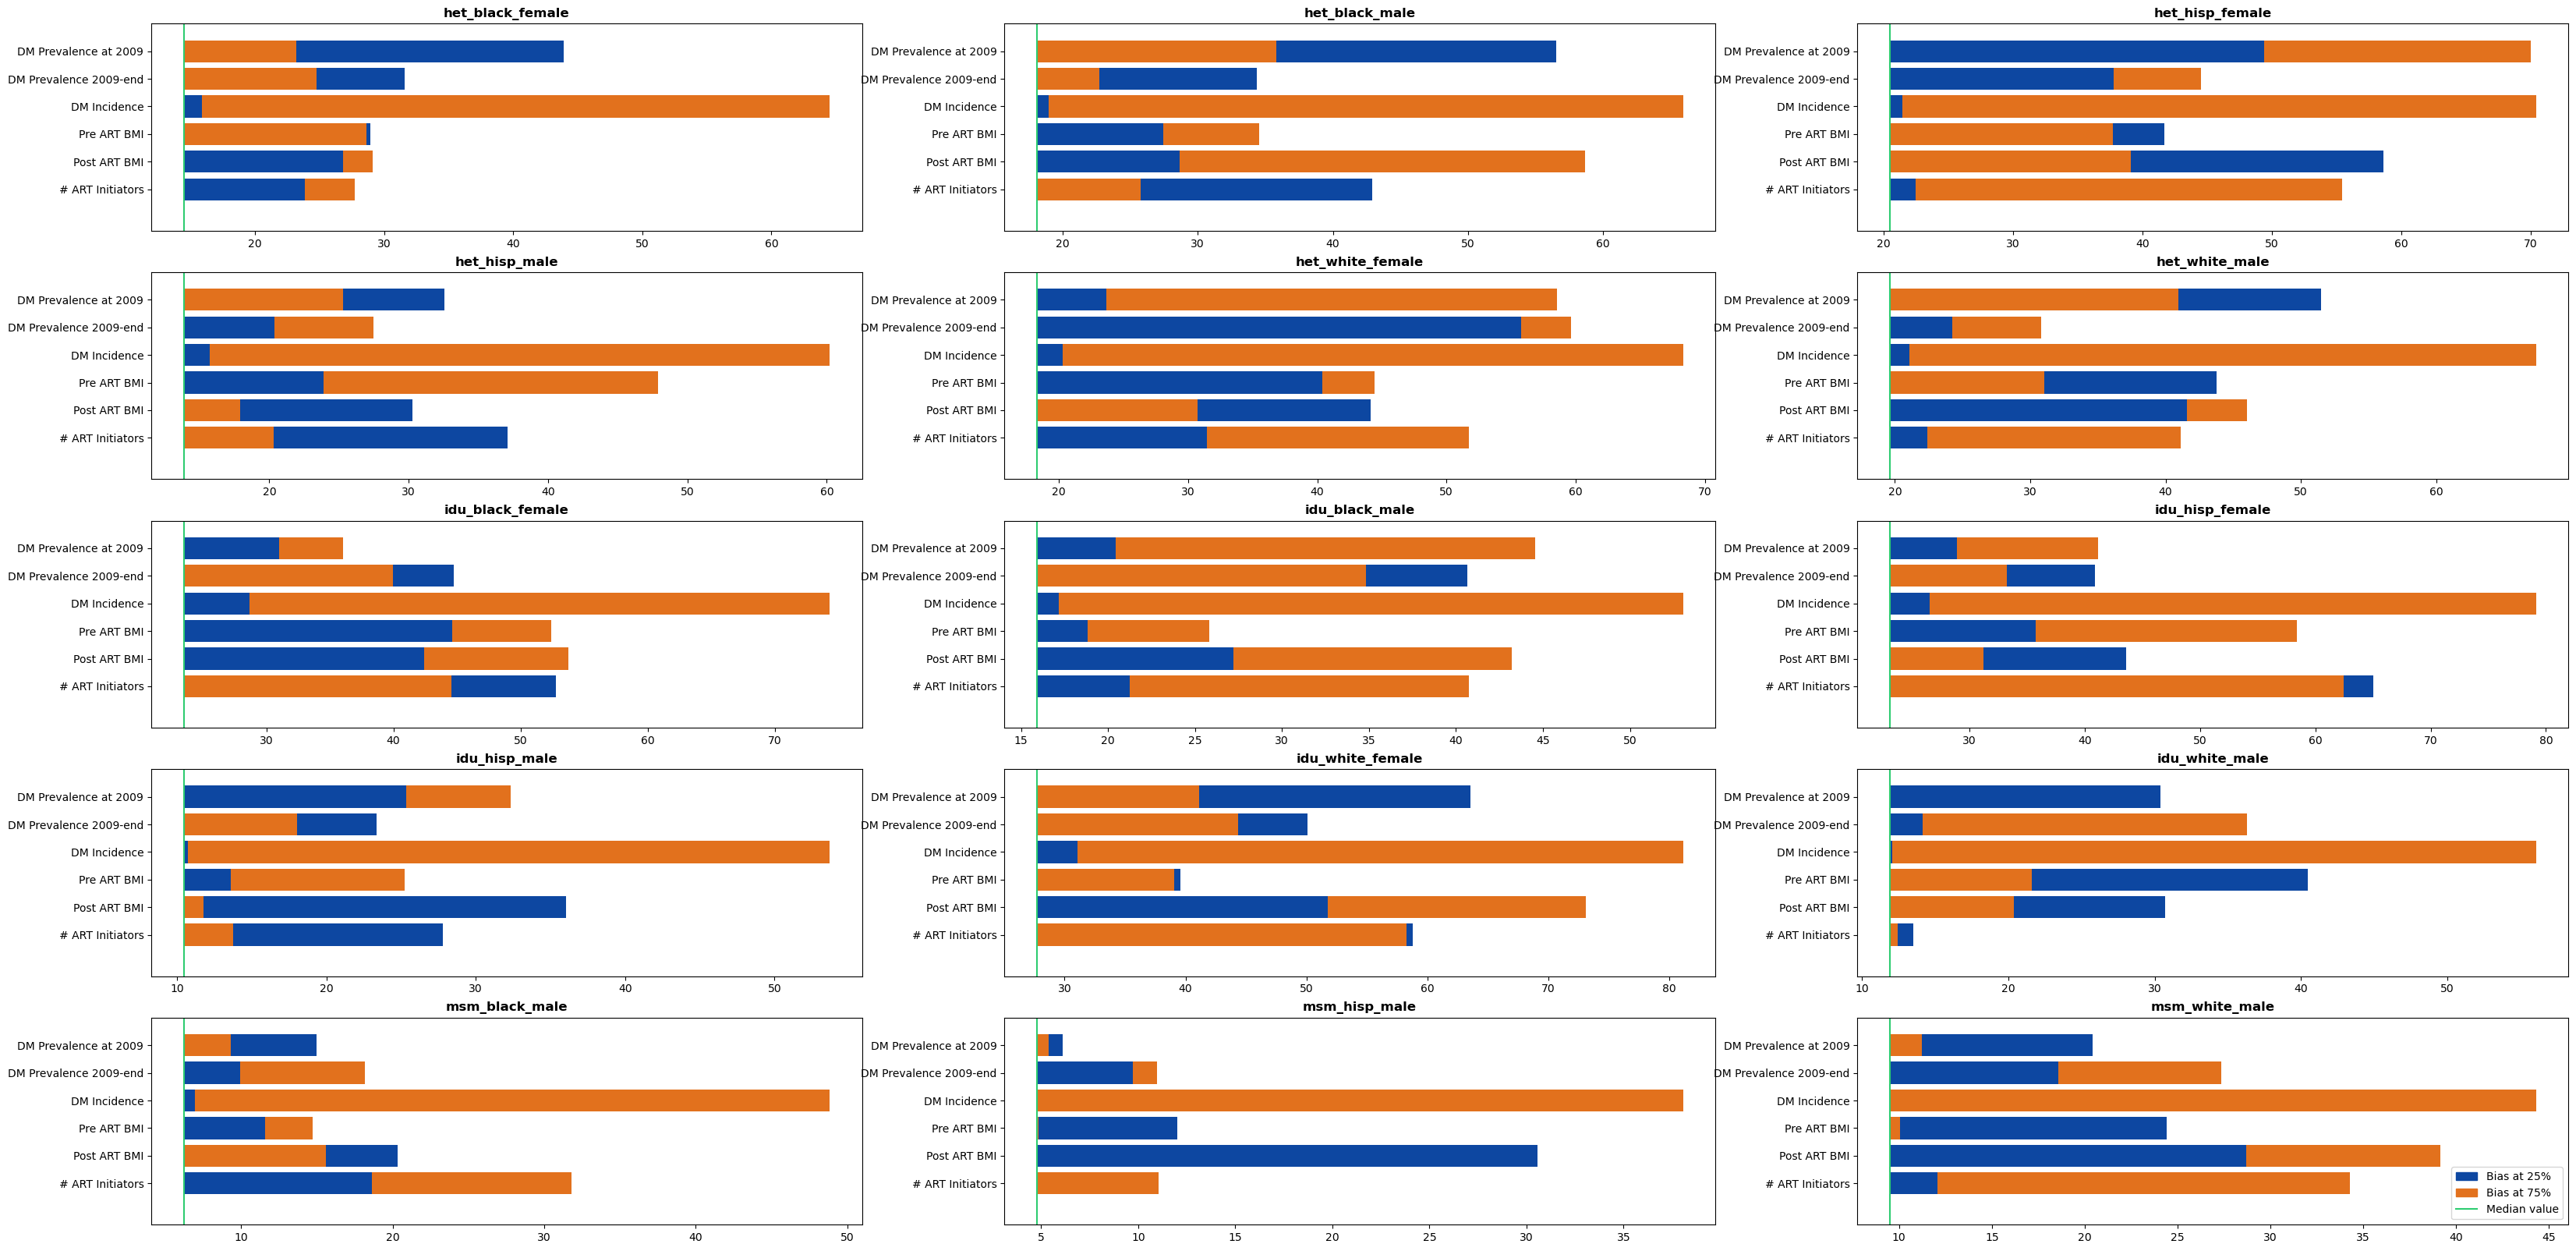

In [212]:
fig, axs = plt.subplots(5, 3, figsize=(40, 20))

plot_groups = np.sort(baseline_tornado_vals.group.unique())

for i, group in enumerate(plot_groups):
    
    group_vals = baseline_tornado_vals[baseline_tornado_vals['group']==group].reset_index(drop=True)
    ax = axs.flatten()[i]
    
    # plot parameters
    yTick_label = group_vals['variable']
    ys = range(len(yTick_label))[::-1]
    height = 0.8
    
    color_5 = '#0d47a1'
    color_95 = '#e2711d'
    color_line = '#2ECC71'

    # Data to be visualized
    value_25 = group_vals.iloc[:,2].values
    value_75 = group_vals.iloc[:,3].values
    base = baseline_risk_median[baseline_risk_median['group']==group]['risk'].values[0]

    # Draw bars
    for y, value, value2 in zip(ys, value_25, value_75):
        if abs(value) < abs(value2):
            ax.broken_barh([(base, value2)], (y - height/2, height),facecolors=[color_95,color_95])
            ax.broken_barh([(base, value)], (y - height/2,height), facecolors=[color_5,color_5])
        else:
            ax.broken_barh([(base, value)], (y - height/2,height), facecolors=[color_5,color_5])
            ax.broken_barh([(base, value2)], (y - height/2, height),facecolors=[color_95,color_95])

    # Add vertical line for median value
    ax.axvline(base, color=color_line, linewidth=1.5, label='Median value')  

    # Modify the graph
    ax.set_ylim([-1.5, 6])
    ax.set_yticks(ys)
    ax.set_yticklabels(yTick_label)
    ax.set_title(group, fontsize=12, fontweight='bold')

    # Add legend
    handles = [Patch(color=color_5, label='Bias at 25%'), Patch(color=color_95, label='Bias at 75%'),
            Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
    plt.legend(handles=handles, loc='lower right')


In [215]:
baseline_tornado_vals

,group,variable,0.25,0.75
0,het_black_female,DM Prevalence at 2009,29.435103,8.698913
1,het_black_male,DM Prevalence at 2009,38.429072,17.758149
2,het_hisp_female,DM Prevalence at 2009,28.910576,49.532468
3,het_hisp_male,DM Prevalence at 2009,18.736118,11.455659
4,het_white_female,DM Prevalence at 2009,5.386415,40.284151
...,...,...,...,...
85,idu_white_female,# ART Initiators,31.110133,30.579202
86,idu_white_male,# ART Initiators,1.615465,0.526164
87,msm_black_male,# ART Initiators,12.417643,25.589225
88,msm_hisp_male,# ART Initiators,0.056311,6.280100


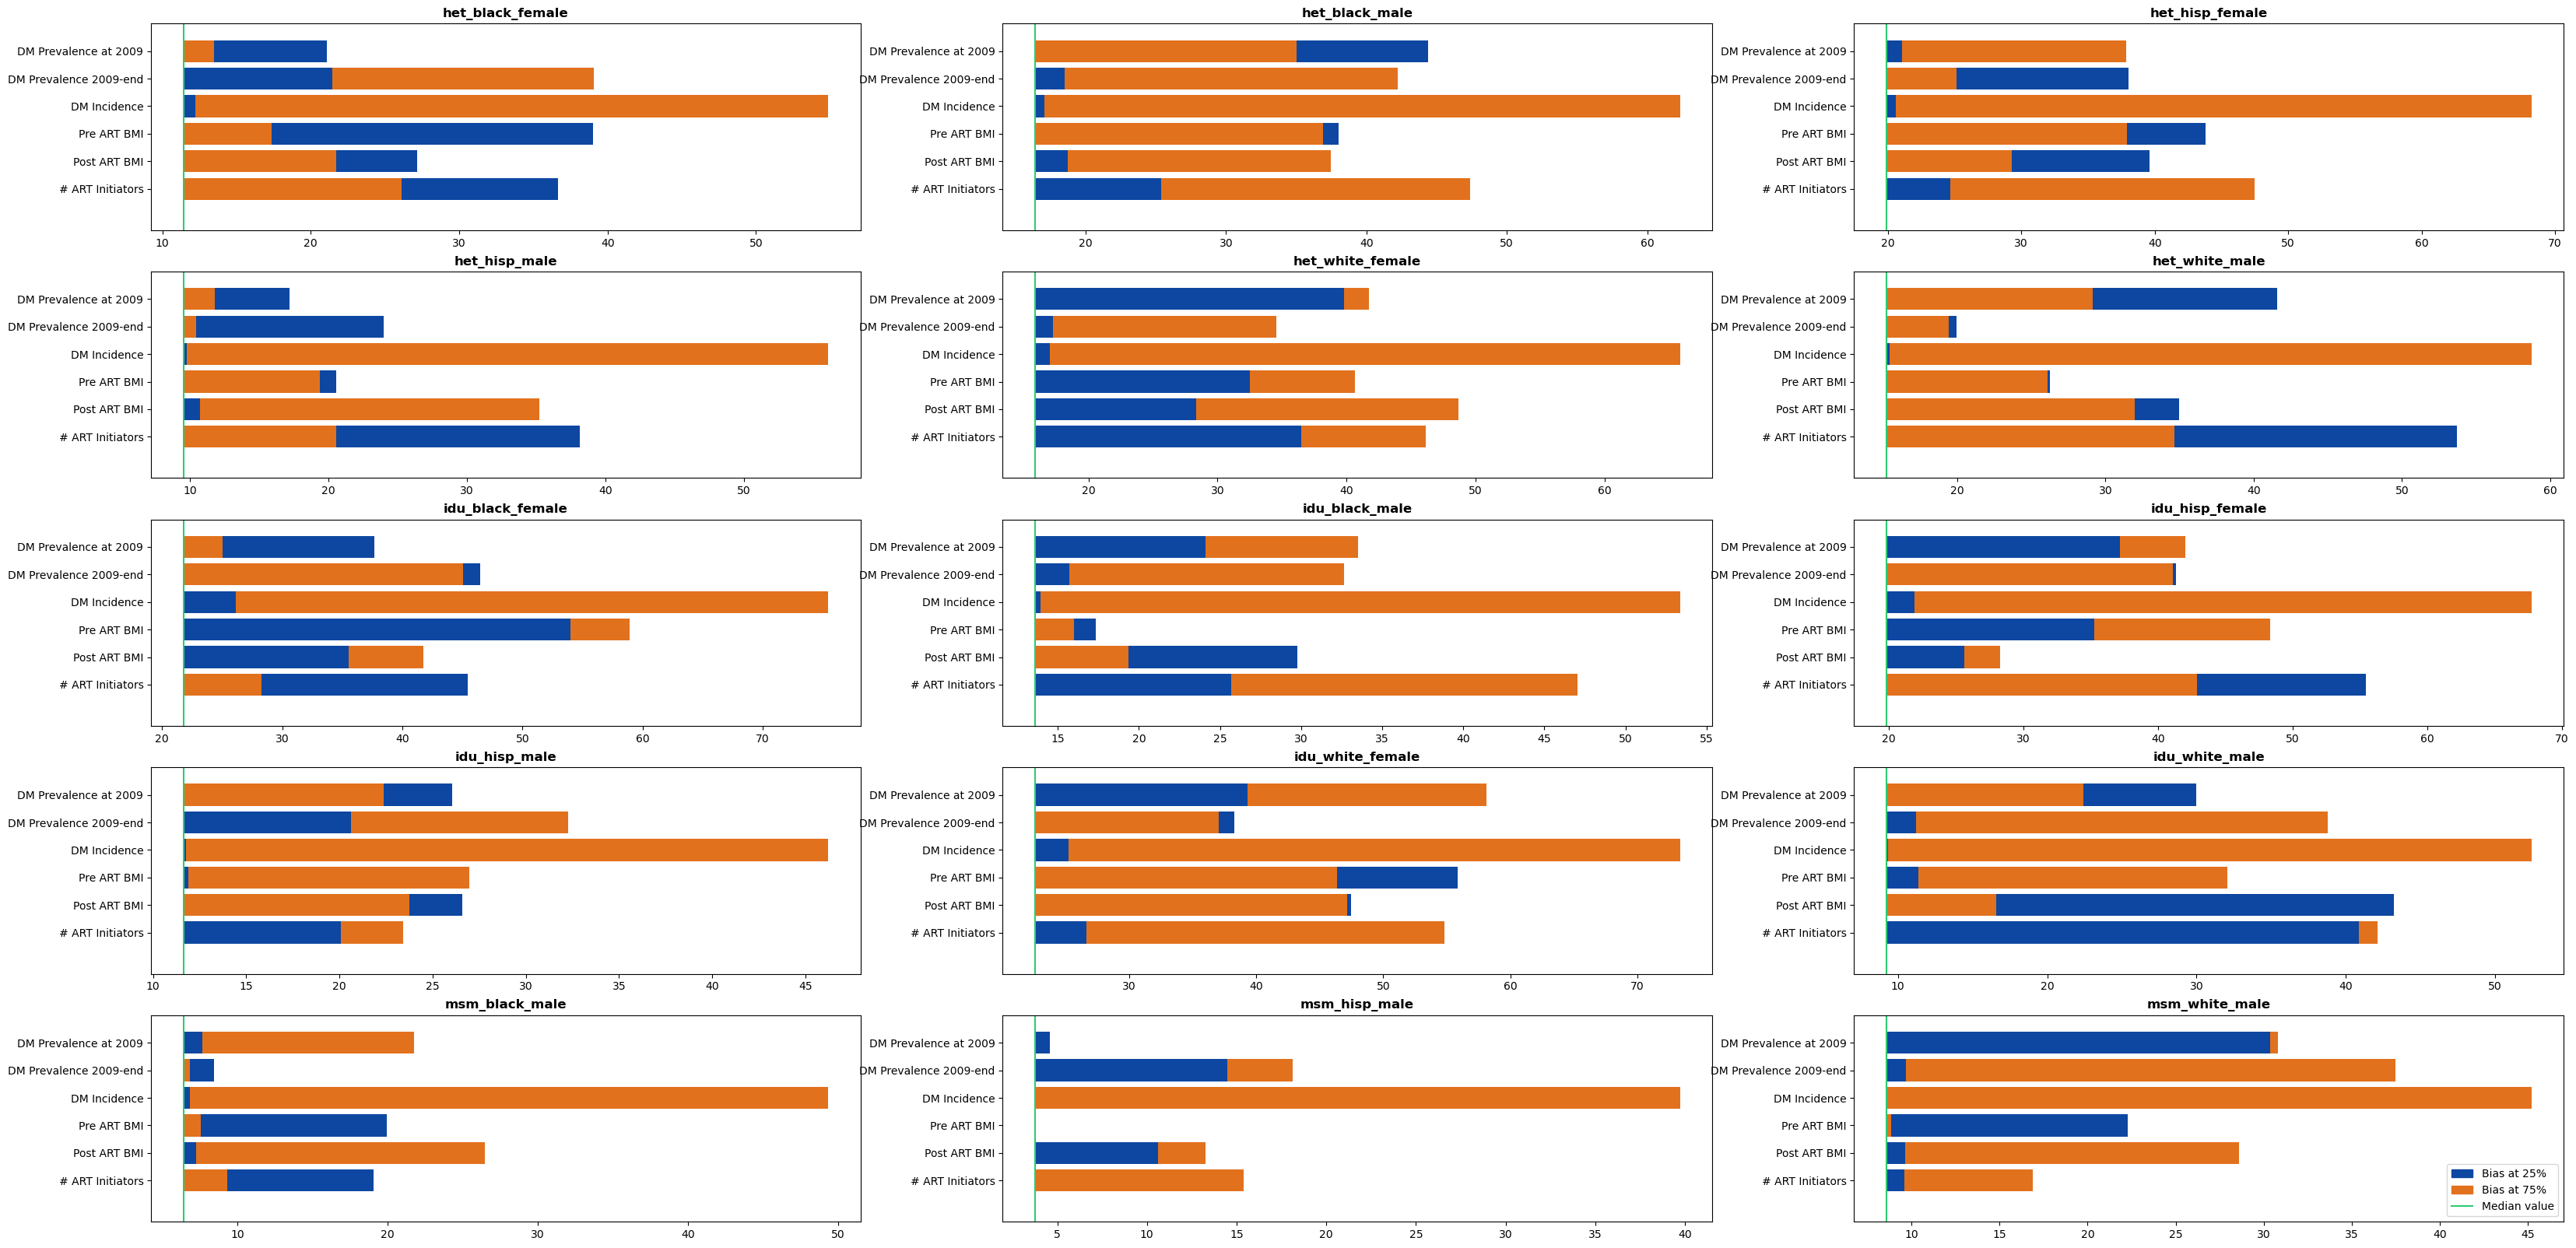

In [213]:
fig, axs = plt.subplots(5, 3, figsize=(40, 20))

plot_groups = np.sort(variable_tornado_vals.group.unique())

for i, group in enumerate(plot_groups):
    
    group_vals = variable_tornado_vals[variable_tornado_vals['group']==group].reset_index(drop=True)
    ax = axs.flatten()[i]
    
    # plot parameters
    yTick_label = group_vals['variable']
    ys = range(len(yTick_label))[::-1]
    height = 0.8
    
    color_5 = '#0d47a1'
    color_95 = '#e2711d'
    color_line = '#2ECC71'

    # Data to be visualized
    value_25 = group_vals.iloc[:,2].values
    value_75 = group_vals.iloc[:,3].values
    base = variable_risk_median[variable_risk_median['group']==group]['risk'].values[0]

    # Draw bars
    for y, value, value2 in zip(ys, value_25, value_75):
        if abs(value) < abs(value2):
            ax.broken_barh([(base, value2)], (y - height/2, height),facecolors=[color_95,color_95])
            ax.broken_barh([(base, value)], (y - height/2,height), facecolors=[color_5,color_5])
        else:
            ax.broken_barh([(base, value)], (y - height/2,height), facecolors=[color_5,color_5])
            ax.broken_barh([(base, value2)], (y - height/2, height),facecolors=[color_95,color_95])

    # Add vertical line for median value
    ax.axvline(base, color=color_line, linewidth=1.5, label='Median value')  

    # Modify the graph
    ax.set_ylim([-1.5, 6])
    ax.set_yticks(ys)
    ax.set_yticklabels(yTick_label)
    ax.set_title(group, fontsize=12, fontweight='bold')

    # Add legend
    handles = [Patch(color=color_5, label='Bias at 25%'), Patch(color=color_95, label='Bias at 75%'),
            Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
    plt.legend(handles=handles, loc='lower right')


In [217]:
variable_tornado_vals

,group,variable,0.25,0.75
0,het_black_female,DM Prevalence at 2009,9.672374,2.092070
1,het_black_male,DM Prevalence at 2009,27.992885,18.635384
2,het_hisp_female,DM Prevalence at 2009,1.168622,17.963535
3,het_hisp_male,DM Prevalence at 2009,7.668993,2.299855
4,het_white_female,DM Prevalence at 2009,23.972050,25.867435
...,...,...,...,...
85,idu_white_female,# ART Initiators,4.041784,32.267123
86,idu_white_male,# ART Initiators,31.642385,32.889740
87,msm_black_male,# ART Initiators,12.672302,2.935498
88,msm_hisp_male,# ART Initiators,0.024062,11.642690


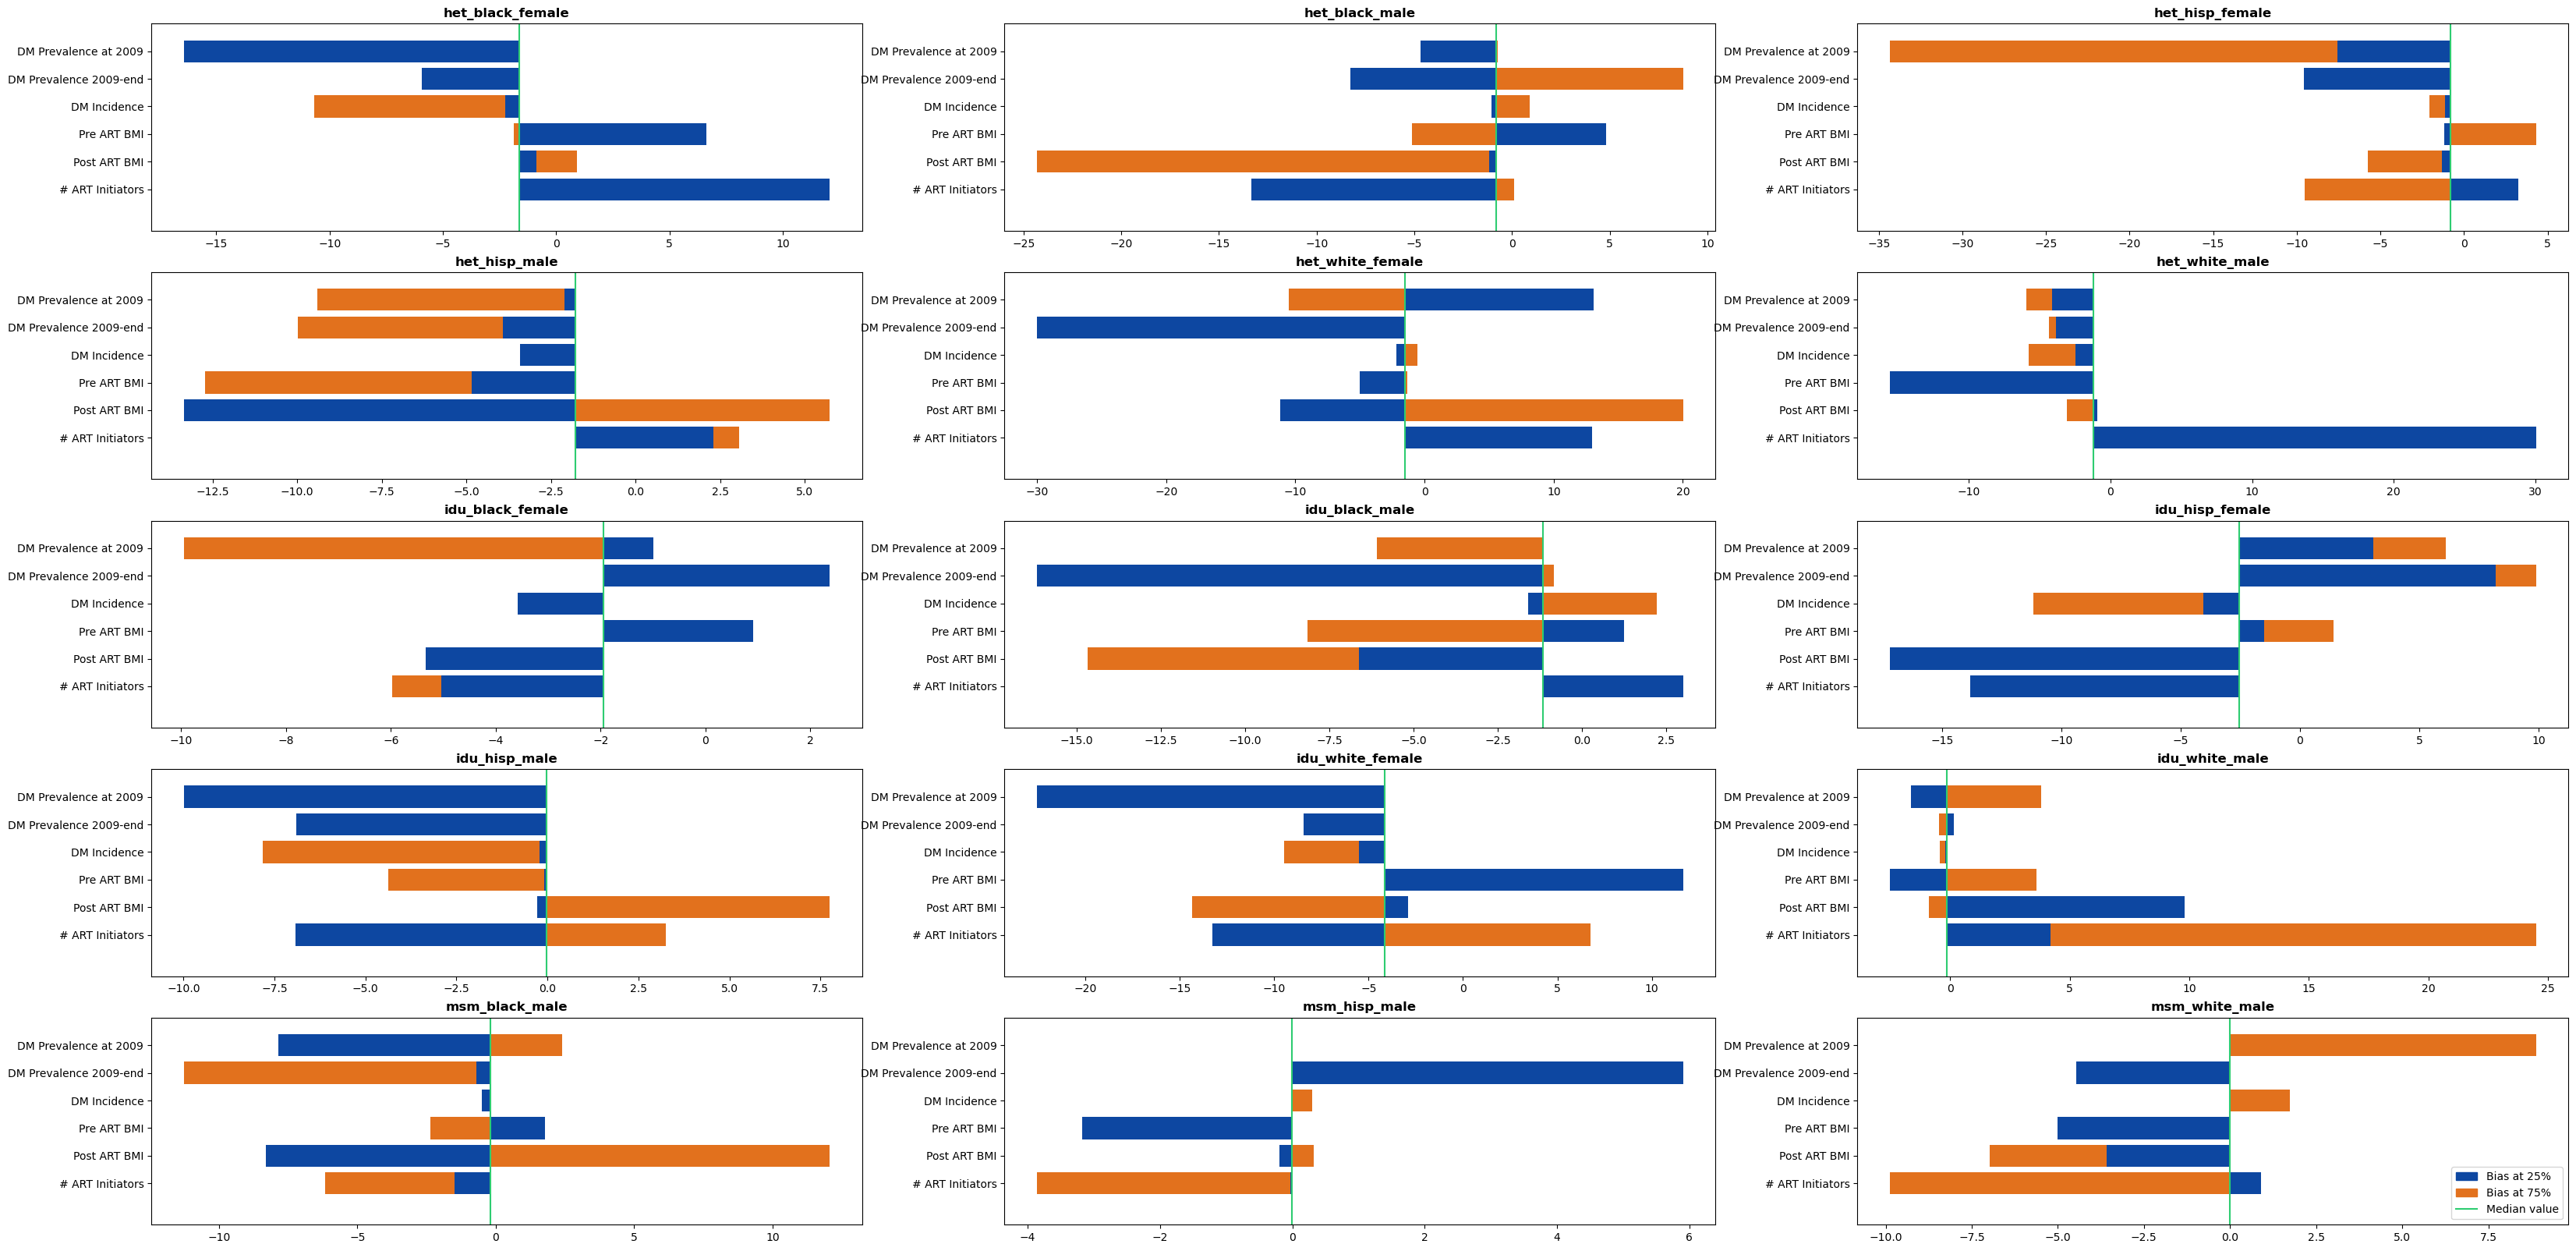

In [214]:
fig, axs = plt.subplots(5, 3, figsize=(40, 20))

plot_groups = np.sort(difference_tornado_vals.group.unique())

for i, group in enumerate(plot_groups):
    
    group_vals = difference_tornado_vals[difference_tornado_vals['group']==group].reset_index(drop=True)
    ax = axs.flatten()[i]
    
    # plot parameters
    yTick_label = group_vals['variable']
    ys = range(len(yTick_label))[::-1]
    height = 0.8
    
    color_5 = '#0d47a1'
    color_95 = '#e2711d'
    color_line = '#2ECC71'

    # Data to be visualized
    value_25 = group_vals.iloc[:,2].values
    value_75 = group_vals.iloc[:,3].values
    base = baseline_risk_difference_df[baseline_risk_difference_df['group']==group]['risk'].values[0]

    # Draw bars
    for y, value, value2 in zip(ys, value_25, value_75):
        if abs(value) < abs(value2):
            ax.broken_barh([(base, value2)], (y - height/2, height),facecolors=[color_95,color_95])
            ax.broken_barh([(base, value)], (y - height/2,height), facecolors=[color_5,color_5])
        else:
            ax.broken_barh([(base, value)], (y - height/2,height), facecolors=[color_5,color_5])
            ax.broken_barh([(base, value2)], (y - height/2, height),facecolors=[color_95,color_95])

    # Draw bars for 25%
    for y, value in zip(ys, value_25):
        ax.broken_barh([(base, value)], (y - height/2,height), facecolors=[color_5,color_5])

    # Add vertical line for median value
    ax.axvline(base, color=color_line, linewidth=1.5, label='Median value')  

    # Modify the graph
    ax.set_ylim([-1.5, 6])
    ax.set_yticks(ys)
    ax.set_yticklabels(yTick_label)
    ax.set_title(group, fontsize=12, fontweight='bold')

    # Add legend
    handles = [Patch(color=color_5, label='Bias at 25%'), Patch(color=color_95, label='Bias at 75%'),
            Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
    plt.legend(handles=handles, loc='lower right')


In [216]:
difference_tornado_vals

,group,variable,0.25,0.75
0,het_black_female,DM Prevalence at 2009,-14.800423,-4.545274
1,het_black_male,DM Prevalence at 2009,-3.867890,0.056963
2,het_hisp_female,DM Prevalence at 2009,-6.794917,-33.554474
3,het_hisp_male,DM Prevalence at 2009,-0.306118,-7.622211
4,het_white_female,DM Prevalence at 2009,14.596574,-9.027319
...,...,...,...,...
85,idu_white_female,# ART Initiators,-9.150294,10.878300
86,idu_white_male,# ART Initiators,4.320519,24.630963
87,msm_black_male,# ART Initiators,-1.281484,-5.967358
88,msm_hisp_male,# ART Initiators,-0.028989,-3.857934
